In [1]:
import pandas as pd

# Load the dataset
file_path = "downloads/NIFTY 100_minute_data.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.head()

,date,open,high,low,close,volume
0,2015-01-09 09:15:00,8300.60,8309.75,8300.60,8308.35,0
1,2015-01-09 09:16:00,8308.35,8308.65,8304.05,8304.20,0
2,2015-01-09 09:17:00,8304.20,8308.20,8304.00,8308.20,0
3,2015-01-09 09:18:00,8308.20,8315.30,8308.20,8315.30,0
4,2015-01-09 09:19:00,8315.30,8316.10,8314.85,8316.10,0


In [53]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from xgboost import XGBClassifier

In [7]:
# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Extract trading day and time
df["trading_day"] = df["date"].dt.date
df["time"] = df["date"].dt.time

# Identify first trading hour (09:15 - 10:15) and last trading hour (14:30 - 15:30)
first_hour_mask = (df["date"].dt.time >= pd.to_datetime("09:15:00").time()) & (df["date"].dt.time <= pd.to_datetime("10:15:00").time())
last_hour_mask = (df["date"].dt.time >= pd.to_datetime("14:30:00").time()) & (df["date"].dt.time <= pd.to_datetime("15:30:00").time())

In [9]:
# Extract first and last hour data
first_hour_data = df[first_hour_mask].groupby("trading_day").agg(
    first_open=("open", "first"),
    first_high=("high", "max"),
    first_low=("low", "min"),
    first_close=("close", "last"),
    first_mean=("close", "mean"),
    first_volatility=("close", "std")
).reset_index()

In [11]:
last_hour_data = df[last_hour_mask].groupby("trading_day").agg(
    last_close=("close", "last")
).reset_index()

In [13]:
# Merge first and last hour data
merged_data = pd.merge(first_hour_data, last_hour_data, on="trading_day")

In [15]:
# Define target variable: 1 if last_close > first_close else 0
merged_data["target"] = (merged_data["last_close"] > merged_data["first_close"]).astype(int)

In [17]:
# Compute additional features
merged_data["first_return"] = (merged_data["first_close"] / merged_data["first_open"]) - 1  # First hour return
merged_data["high_low_range"] = merged_data["first_high"] - merged_data["first_low"]  # First hour range
merged_data["sma_5"] = merged_data["first_mean"].rolling(window=5, min_periods=1).mean()
merged_data["sma_10"] = merged_data["first_mean"].rolling(window=10, min_periods=1).mean()

In [19]:
# Compute RSI manually
def compute_rsi(series, window=5):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / (loss + 1e-9)  # Small value to avoid division by zero
    return 100 - (100 / (1 + rs))

In [21]:
merged_data["rsi"] = compute_rsi(merged_data["first_close"], window=5)

In [23]:
# Compute Bollinger Bands
rolling_mean = merged_data["first_close"].rolling(window=5, min_periods=1).mean()
rolling_std = merged_data["first_close"].rolling(window=5, min_periods=1).std()
merged_data["bb_upper"] = rolling_mean + (2 * rolling_std)
merged_data["bb_lower"] = rolling_mean - (2 * rolling_std)

# Drop NaN values after feature computation
merged_data = merged_data.dropna()

In [25]:
# Select features and target
X = merged_data[[
    "first_open", "first_high", "first_low", "first_close", "first_mean", "first_volatility",
    "first_return", "high_low_range", "sma_5", "sma_10", "rsi", "bb_upper", "bb_lower"
]]
y = merged_data["target"]

In [33]:
# Define split point (e.g., use 80% of the oldest data for training)
split_idx = int(len(X) * 0.8)

# Split based on time order
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [63]:

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(70, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(40, activation="relu"),
    Dropout(0.1),
    Dense(1, activation="sigmoid")  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=50, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

# Get predictions and classification report
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype(int)
nn_report = classification_report(y_test, y_pred_nn)

# Display accuracy and classification report
test_acc, nn_report

Epoch 1/50


C:\Users\Rajat\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5002 - loss: 0.7075 - val_accuracy: 0.5292 - val_loss: 0.6925
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5218 - loss: 0.6917 - val_accuracy: 0.5372 - val_loss: 0.6897
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5260 - loss: 0.6909 - val_accuracy: 0.5332 - val_loss: 0.6910
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5381 - loss: 0.6900 - val_accuracy: 0.5513 - val_loss: 0.6880
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5621 - loss: 0.6857 - val_accuracy: 0.5272 - val_loss: 0.6905
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5366 - loss: 0.6913 - val_accuracy: 0.5433 - val_loss: 0.6867
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5398 - loss: 0.6861 - val_accuracy: 0.5433 - val_loss: 0.6879
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5590 - loss: 0.6836 - val_accuracy: 0.5412 - val_loss: 0.6878
Epo

(0.5352112650871277,
 '              precision    recall  f1-score   support\n\n           0       0.55      0.50      0.52       252\n           1       0.53      0.58      0.55       245\n\n    accuracy                           0.54       497\n   macro avg       0.54      0.54      0.53       497\nweighted avg       0.54      0.54      0.53       497\n')

In [65]:
merged_data['signal'] = model.predict(scaler.transform(X))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step


In [73]:
merged_data['predicted_signal'] = merged_data['signal'].apply(lambda x: 1 if x>0.5 else 0) 

In [91]:
merged_data.set_index('trading_day',inplace = True)

In [97]:
# **Calculate daily returns for each strategy**
merged_data["intraday_daily_return"] = np.where(
    merged_data["predicted_signal"] == 1,
    (merged_data["last_close"] / merged_data["first_close"]) - 1,  # Buy if predicted up
    (merged_data["first_close"] / merged_data["last_close"]) - 1  # Short-sell if predicted down
)

merged_data["buy_hold_daily_return"] = (merged_data["last_close"] / merged_data["first_close"]) - 1

# **Start with ₹1 investment in each strategy**
merged_data["intraday_wealth"] = (1 + merged_data["intraday_daily_return"]).cumprod()
merged_data["buy_hold_wealth"] = merged_data['last_close']/merged_data['last_close'][0]

C:\Users\Rajat\AppData\Local\Temp\ipykernel_5780\2217210859.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_data["buy_hold_wealth"] = merged_data['last_close']/merged_data['last_close'][0]


In [115]:
merged_data['intraday_daily_return'].std()*np.sqrt(252)

0.12280561590419042

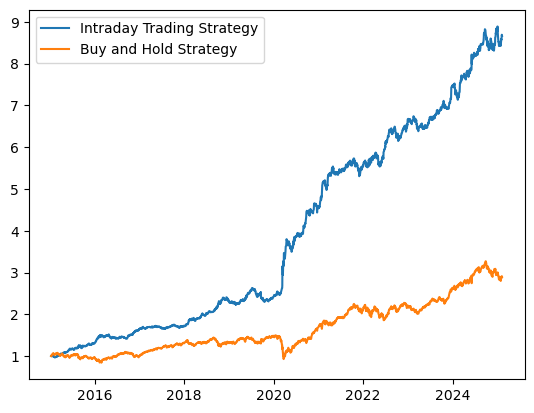

In [117]:
plt.plot(merged_data['intraday_wealth'] , label = 'Intraday Trading Strategy')
plt.plot(merged_data["buy_hold_wealth"] , label = 'Buy and Hold Strategy')
plt.legend()